#Введение в pruning

Успех нейронных сетей во многом обуславливается их глубиной, но одновременно с ростом качества, растет время работы (как во время обучения, так и во время валидации) и размер. Метод называющийся pruning призван уменьшить размер сети и время инференса. Выделяют две главные категории pruning'a, первая: filter pruning, когда мы избавляемся от лишних вычислений, благодаря "обрезанию" неэффективных "нейронов"; вторая: weight pruning, когда зануляются веса сети, делая ее более разряженной. 

#Обучение и загрузка датасета (Шаги 2-4)

In [1]:
from google.colab import drive
drive.mount('content/')

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


In [2]:
import torch
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as accuracy
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering, AffinityPropagation
import warnings

import random
import numpy as np
import os
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import time

warnings.filterwarnings('ignore')

In [3]:
class CFG:
  epochs = 3 #для получения предложенных весов тренировка производилась на 100 эпохах, для демонстрационных целей это количество было уменьшено
  lr = 0.1
  momentum = 0.9
  weight_decay = 1e-4
  seed = 7

Так как resnet20 известная архитектура можем взять ее реализацию из открытых источников.

In [4]:
!git clone https://github.com/akamaster/pytorch_resnet_cifar10.git

fatal: destination path 'pytorch_resnet_cifar10' already exists and is not an empty directory.


In [5]:
import sys
sys.path.insert(0,'/content/pytorch_resnet_cifar10')
import resnet
sys.path.insert(0,'/content/')

Во время обучения используется только пара "легких аугментаций", этого достаточно чтобы достичь качества свыше 90% (как по метрике accuracy, так и по метрике precision, каждую из которых можно перевести как точность). Датасет CIFAR10 загружаем и обрабатываем в автоматическом режиме.

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainset = datasets.CIFAR10(root='/content', train=True, download=True, transform=data_transforms['train'])
valset = datasets.CIFAR10(root='/content', train=False, download=True, transform=data_transforms['val'])

dataloaders = {'train' : DataLoader(trainset, batch_size=200, shuffle=True),
               'val' : DataLoader(valset, batch_size=200, shuffle=False)}

Files already downloaded and verified
Files already downloaded and verified


Воспользуемся той же функцией потерь и методом градиентного спуска что и в оригинальной статье. (https://arxiv.org/abs/1512.03385)

In [7]:
seed_everything(CFG.seed)
model = resnet.resnet20().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=CFG.momentum, weight_decay=CFG.weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

In [8]:
train_val(CFG, model, dataloaders, criterion, optimizer, scheduler, device)

Epoch 0


100%|██████████| 250/250 [00:28<00:00,  8.73it/s]


Phase train
Accuracy 0.37684
Loss 1.6873382058143616



100%|██████████| 50/50 [00:02<00:00, 18.86it/s]


Phase val
Accuracy 0.4459
Loss 1.615683946609497

Epoch 1


100%|██████████| 250/250 [00:29<00:00,  8.61it/s]


Phase train
Accuracy 0.56108
Loss 1.2010771565437317



100%|██████████| 50/50 [00:02<00:00, 18.55it/s]


Phase val
Accuracy 0.5799
Loss 1.1994066381454467

Epoch 2


100%|██████████| 250/250 [00:28<00:00,  8.77it/s]


Phase train
Accuracy 0.6599
Loss 0.9591229903697968



100%|██████████| 50/50 [00:02<00:00, 19.17it/s]


Phase val
Accuracy 0.643
Loss 1.013540394306183



In [9]:
validate(model, dataloaders)

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Аккуратность на тестовом датасете равна 0.643
Точность на тестовом датасете равна 0.6756250451428535


# Pruning (шаг 5)

Загружаем веса в нашу модель.

In [10]:
model.load_state_dict(torch.load('/content/content/MyDrive/resnet20_cifar_weights.pt'))
validate(model, dataloaders)

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Аккуратность на тестовом датасете равна 0.908
Точность на тестовом датасете равна 0.9076657641779079


Посмотрим на то как работает pruning в трех разных случаях:

**Когда мы одинаково уменьшаем число кластеров относительно количества первоначальных сверточных слоев**

In [11]:
prune(model, regime='reduce', k=3)
time.sleep(0.3)
validate(model, dataloaders)
model.load_state_dict(torch.load('/content/content/MyDrive/resnet20_cifar_weights.pt'));

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Аккуратность на тестовом датасете равна 0.6363
Точность на тестовом датасете равна 0.7537858244273183


**Когда мы используем одинаковое количество кластеров для всех слоев**

In [12]:
prune(model, regime='union', k=10)
time.sleep(0.3)
validate(model, dataloaders)
model.load_state_dict(torch.load('/content/content/MyDrive/resnet20_cifar_weights.pt'));

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Аккуратность на тестовом датасете равна 0.1152
Точность на тестовом датасете равна 0.029143750728154366


**Когда мы используем в центральном слое меньше кластеров чем в крайних**

In [13]:
prune(model, regime='custom', k=10)
time.sleep(0.3)
validate(model, dataloaders)
model.load_state_dict(torch.load('/content/content/MyDrive/resnet20_cifar_weights.pt'));

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Аккуратность на тестовом датасете равна 0.1006
Точность на тестовом датасете равна 0.043225740853643155


#Построение графиков и выводы (шаг 6)

### Как мы можем заметить самым эффективным методом является уменьшение числа кластеров относительного первоначального числа слоев. Построим для этого случая график и посмотрим что происходит с accuracy по мере уменьшения числа слоев.

In [14]:
accs = []
for i in range(1, 10):
    prune(model, regime='reduce', k=i)
    time.sleep(0.3)
    accs.append(validate(model, dataloaders, verbose=False))
    model.load_state_dict(torch.load('/content/content/MyDrive/resnet20_cifar_weights.pt'));


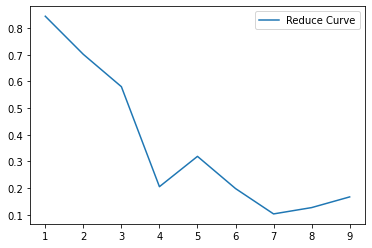

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1,10), accs, label='Reduce Curve')
plt.legend()
plt.show()

**С уменьшением числа кластеров падает и точность сети. Реализованный метод работает плохо, так как точность сети подает значительно, при совсем незначительных приростах в скорости работы**

# Предложения по улучшению (Шаг 7)

1. Мы исопльзовали самый простой алгоритм кластеризации (KMeans), который плохо справляется с кластеризацией не сферических данных. Так что стоит попробовать другие алгоритмы кластеризации.
2. В данном подходе мы обучали кластеризацию на векторе признаков свертки, не учитывающем ее пространственную корреляцию (то есть на линейном представлении свертки), в результате чего потеряли важную информацию. Это привело к бОльшой потере в качестве.